In [442]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score
from sklearn.preprocessing import MinMaxScaler
import numpy as np

df = pd.read_parquet('../data/rucphen_precipitation_clean.parquet')

In [443]:
def create_plot(df, x,xlabel, y, ylabel, title):
    # Create a line plot using seaborn
    plt.figure(figsize=(10, 6))
    sns.lineplot(data=df, x = x, y = y)

    # Set labels and title
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)

    # Display the plot
    plt.show()
def show_df(df, start = pd.to_datetime('2020-02-01 08:00:00'), end = pd.to_datetime('2023-11-01 08:00:00')):
    # Define the start and end timestamps
    start_timestamp = start
    end_timestamp = end

    # Create a boolean mask for the specified time range
    mask = (df['timestamp'] >= start_timestamp) & (df['timestamp'] < end_timestamp)

    # Apply the mask to get the desired slice of the DataFrame
    result_df = df[mask]

    create_plot(result_df, 'timestamp','Timestamp', 'precipitation','mm', 'Line Plot: Rainfall over time')
    create_plot(result_df, 'timestamp','Timestamp', 'percentage','%', 'Line Plot: Percentage full over time')


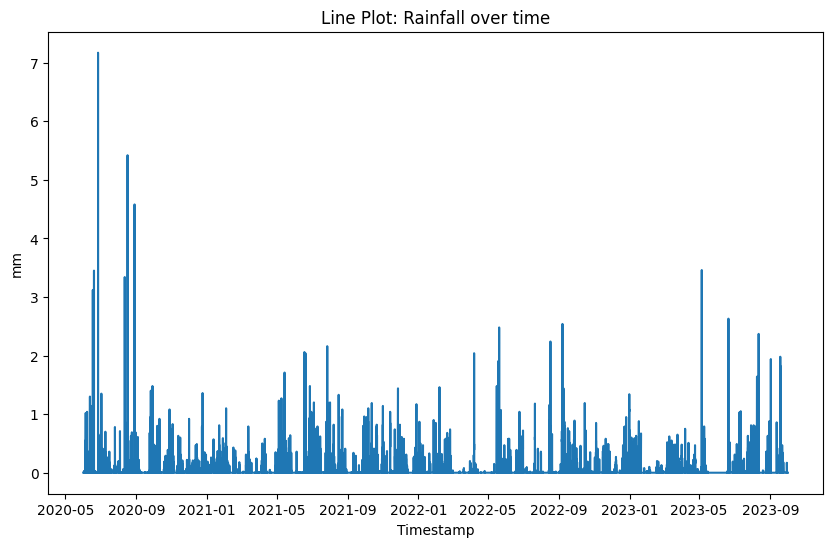

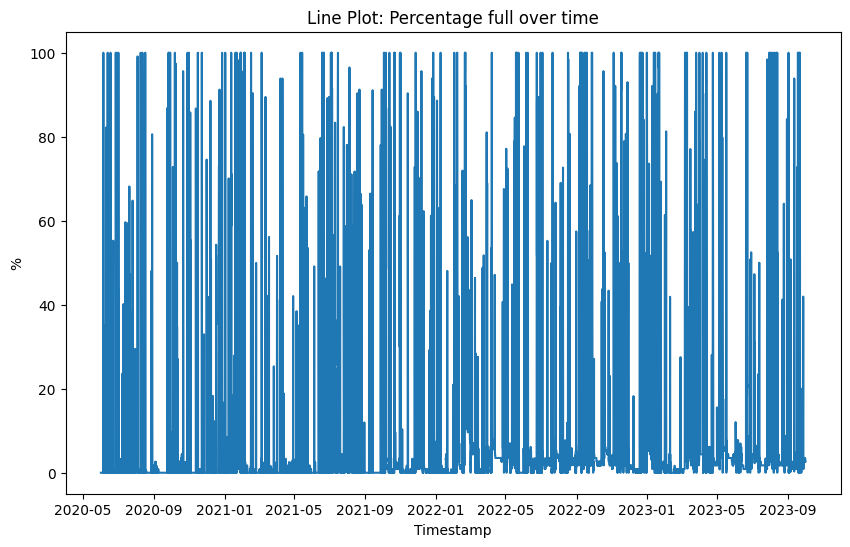

In [444]:
show_df(df, pd.to_datetime('2020-06-01 08:00:00'), pd.to_datetime('2023-10-01 08:00:00'))

/tmp/ipykernel_5074/1151599856.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_reduced.fillna(0, inplace=True)


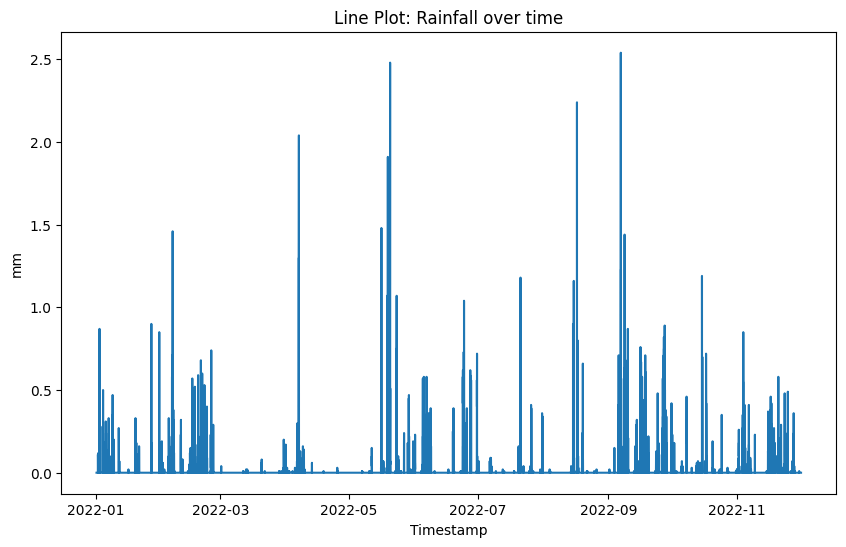

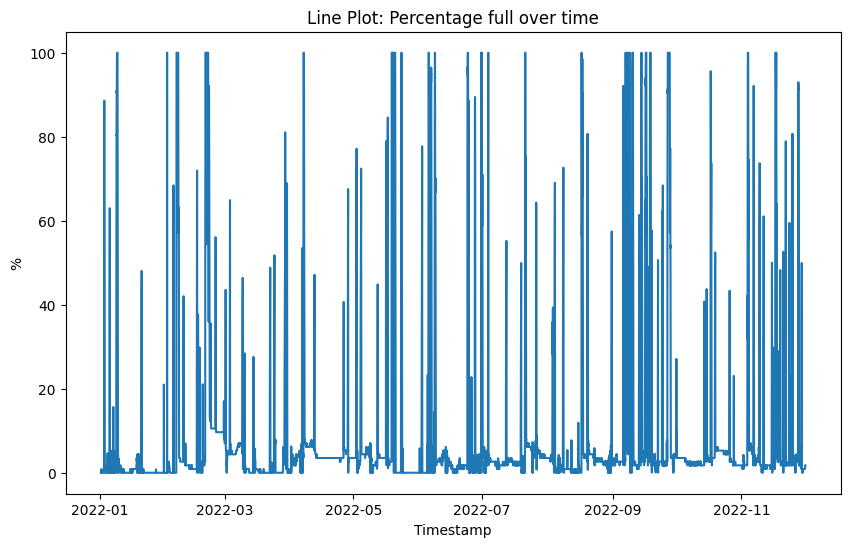

In [445]:
start_timestamp = pd.to_datetime('2022-01-01 08:00:00')
end_timestamp = pd.to_datetime('2022-12-01 08:00:00')

# Create a boolean mask for the specified time range
mask = (df['timestamp'] >= start_timestamp) & (df['timestamp'] < end_timestamp)

# Apply the mask to get the desired slice of the DataFrame
df_reduced = df[mask]
df_reduced.fillna(0, inplace=True)
show_df(df_reduced)

In [446]:
def df_features_of_df(df: pd.DataFrame):
    # Datetime features
    # Extracting features
    df_features = df.copy()
    print(df_features)
    # df_features['hour'] = df_features['timestamp'].dt.hour
    # df_features['dayofweek'] = df_features['timestamp'].dt.hour
    # df_features['month'] = df_features['timestamp'].dt.hour

    # Define the lags you want
    precipitation_lags = [1, 2, 3, 4]
    # percentage_lags = [1]

    df_features['precipitation_20-60'] = df_features['precipitation'].shift(5).rolling(8, min_periods=1).sum()
    df_features['precipitation_60-90'] = df_features['precipitation'].shift(13).rolling(6, min_periods=1).sum()
    # df_features['percentage_0-30'] = df_features['percentage'].rolling(6, min_periods=1).sum()
    df_features['percentage_0-60'] = df_features['percentage'].shift(1).rolling(12, min_periods=1).sum()
    df_features['percentage_60-90'] = df_features['percentage'].shift(13).rolling(6, min_periods=1).sum()

    # Add lag features for 'precipitation'
    for lag in precipitation_lags:
        df_features[f'precipitation_lag_{lag}'] = df_features['precipitation'].shift(lag)

    # # Add lag features for 'percentage'
    # for lag in percentage_lags:
    #     df_features[f'percentage_lag_{lag}'] = df_features['percentage'].shift(lag)

    return df_features

In [447]:
df_features = df_features_of_df(df_reduced)
# Drop rows with NaN values introduced by the lag operation
df_features.dropna(inplace=True)

# Reset index to integers
df_features = df_features.reset_index(drop=True)
df_features.head()

                 timestamp  precipitation  percentage
313409 2022-01-01 08:00:00            0.0       0.000
313410 2022-01-01 08:05:00            0.0       0.000
313411 2022-01-01 08:10:00            0.0       0.000
313412 2022-01-01 08:15:00            0.0       0.000
313413 2022-01-01 08:20:00            0.0       0.000
...                    ...            ...         ...
409004 2022-12-01 07:35:00            0.0       1.754
409005 2022-12-01 07:40:00            0.0       1.754
409006 2022-12-01 07:45:00            0.0       1.754
409007 2022-12-01 07:50:00            0.0       1.754
409008 2022-12-01 07:55:00            0.0       1.754

[95600 rows x 3 columns]


,timestamp,precipitation,percentage,precipitation_20-60,precipitation_60-90,percentage_0-30,percentage_30-60,precipitation_lag_1,precipitation_lag_2,precipitation_lag_3,precipitation_lag_4
0,2022-01-01 09:05:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2022-01-01 09:10:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2022-01-01 09:15:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2022-01-01 09:20:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2022-01-01 09:25:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [448]:
# Extract features and target from the DataFrame

X = df_features.loc[:, df_features.columns != 'percentage']
X.drop(columns='timestamp', inplace=True)
y = df_features['percentage']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, shuffle=False)


# Standardize Data
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

def scale(df: pd.DataFrame):
    return scaler.transform(df)

/tmp/ipykernel_5074/621024268.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.drop(columns='timestamp', inplace=True)


In [449]:
print("Number of samples in X_train_scaled:", len(X_train_scaled))
print("Number of samples in y_train:", len(y_train))
print("Number of samples in X_test_scaled:", len(X_test_scaled))
print("Number of samples in y_test:", len(y_test))


Number of samples in X_train_scaled: 47793
Number of samples in y_train: 47793
Number of samples in X_test_scaled: 47794
Number of samples in y_test: 47794


In [450]:
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.metrics import make_scorer, mean_squared_error, r2_score
train = True
if train == True:
    # Train SVM Model
    model = svm.SVR(kernel= 'linear')

    # Assuming X_train_scaled, y_train are already defined
    param_grid = {'C': [10, 50, 100], 'gamma': [0.001,0.01, 0.1, 1], 'epsilon': [0.1, 0.2, 0.5]}

    # Define scoring using multiple metrics
    scoring = {'MSE': make_scorer(mean_squared_error, greater_is_better=False),
            'R2': make_scorer(r2_score)}

    # TimeSeriesSplit with 5 splits
    tscv = TimeSeriesSplit(n_splits=5)

    grid_search = GridSearchCV(model, param_grid, cv=tscv, scoring=scoring,refit='R2', n_jobs=-1)

    grid_search.fit(X_train_scaled, y_train)
    
    # Save the model
    from joblib import dump
    dump(grid_search, 'svm.joblib')
else:
    from joblib import load
    grid_search = load('svm.joblib')

In [451]:
import pickle

best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

print(best_params)
print(best_model)


{'C': 10, 'epsilon': 0.5, 'gamma': 0.001}
SVR(C=10, epsilon=0.5, gamma=0.001, kernel='linear')


Mean Squared Error: 4.320698353022154
r2: 0.9909772413414379


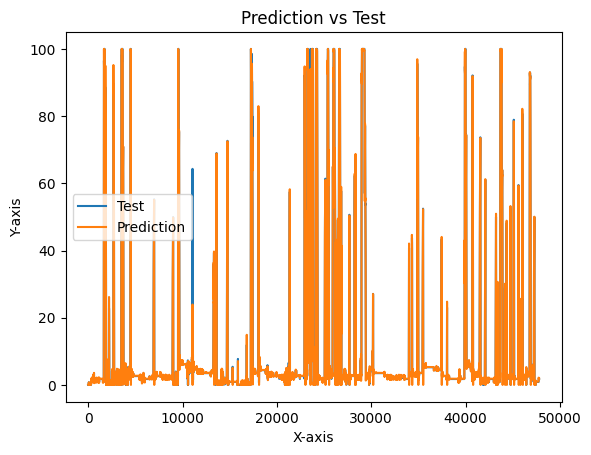

In [452]:
def predict(X_test_scaled, model):
    # Make Predictions
    return best_model.predict(X_test_scaled)

def evaluate(y_test, predictions):
    y_test_converted = y_test.to_numpy()

    # Use np.clip to limit values between 0 and 100
    predictions_clipped = np.clip(predictions, 0, 100)

    # Evaluate the Model
    mse = mean_squared_error(y_test_converted, predictions_clipped)
    print(f'Mean Squared Error: {mse.item()}')

    r2 = r2_score(y_test_converted, predictions_clipped)
    print(f'r2: {r2.item()}')

    # Plotting
    plt.plot(y_test_converted, label='Test')
    plt.plot(predictions_clipped, label='Prediction')

    # Adding labels and title
    plt.xlabel('X-axis')
    plt.ylabel('Y-axis')
    plt.title('Prediction vs Test')

    # Adding legend
    plt.legend()

    # Display the plot
    plt.show()

def predict_and_evaluate(X_test_scaled, y_test, model):
    predictions = predict(X_test_scaled, model)
    evaluate(y_test, predictions)

predict_and_evaluate(X_test_scaled, y_test, best_model)

                  Name       Score
0     percentage_30-60  -69.598926
1  precipitation_20-60   -0.262451
2  precipitation_lag_2   -0.136845
3        precipitation    0.077768
4  precipitation_lag_3    0.188855
5  precipitation_lag_1    0.405420
6  precipitation_lag_4    0.776548
7  precipitation_60-90    1.251931
8      percentage_0-30  168.990565


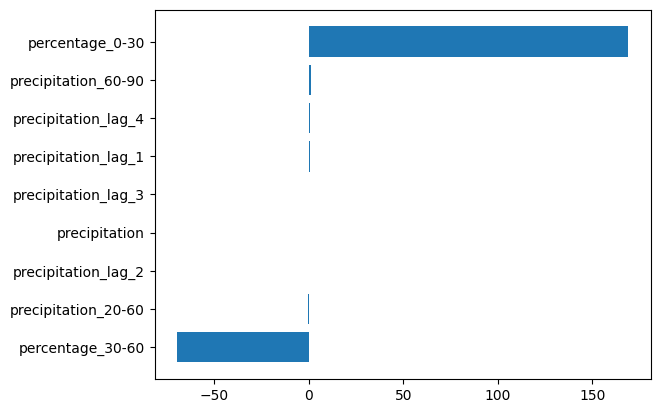

In [453]:
from matplotlib import pyplot as plt
from sklearn import svm

def f_importances(coef, names):
    # Convert coef to a numpy array
    imp = np.array(coef).ravel()  # Ensure 1D array
    
    # Sort imp and names
    sorted_indices = np.argsort(imp)
    imp = imp[sorted_indices]
    names = [names[i] for i in sorted_indices]

    df = pd.DataFrame({'Name': names, 'Score': imp})
    print(df.head(20))
    # Create a horizontal bar plot
    plt.barh(range(len(names)), imp, align='center')
    
    # Set y-axis labels
    plt.yticks(range(len(names)), names)
    
    # Display the plot
    plt.show()

f_importances(best_model.coef_, X.columns.array.tolist())


In [454]:
from datetime import timedelta
def predict_one_step(X_test:pd.DataFrame, X_weather:pd.DataFrame):
    X_test_filtered = X_test.drop(columns=['percentage', 'timestamp'])
    X_test_scaled = scale(X_test_filtered.tail(1))
    input = X_test.tail(1)
    percentage = predict(X_test_scaled, best_model)[0]
    percentage_clipped = np.clip(percentage,0,100)
    print('here', percentage_clipped)
    future_timestamp = input['timestamp'].values[0] + + np.timedelta64(5, 'm')
    precipitation_row = X_weather[future_timestamp == X_weather['timestamp']].iloc[0]
    new_row = {'timestamp':future_timestamp, 'precipitation': precipitation_row['precipitation'], 'percentage': percentage_clipped}
    df_unprocessed = pd.concat([X_test[['timestamp', 'precipitation', 'percentage' ]], pd.DataFrame([new_row])], ignore_index=True)
    return df_features_of_df(df_unprocessed)
    
X_original = df_features_of_df(df_reduced)
first_nan_index = X_original['percentage_60-90'].notna().idxmax()
X_result = X_original.copy()
X_result = X_result[X_result.index <= first_nan_index]
for i in range(0,int(len(X_original)/50)):
    X_result = predict_one_step(X_result,X_original)


X_result[['percentage', 'precipitation']].plot()
X_result

                 timestamp  precipitation  percentage
313409 2022-01-01 08:00:00            0.0       0.000
313410 2022-01-01 08:05:00            0.0       0.000
313411 2022-01-01 08:10:00            0.0       0.000
313412 2022-01-01 08:15:00            0.0       0.000
313413 2022-01-01 08:20:00            0.0       0.000
...                    ...            ...         ...
409004 2022-12-01 07:35:00            0.0       1.754
409005 2022-12-01 07:40:00            0.0       1.754
409006 2022-12-01 07:45:00            0.0       1.754
409007 2022-12-01 07:50:00            0.0       1.754
409008 2022-12-01 07:55:00            0.0       1.754

[95600 rows x 3 columns]


KeyError: 'percentage_60-90'